In [230]:
# Import dependencies 
import pandas as pd
import numpy as np
import random
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt


In [231]:
# Load the news_articles.csv into a DataFrame.
stock_data_df = pd.read_csv('Resources/stock_yfinance_data.csv')
tweet_data_df = pd.read_csv('Resources/stock_tweets.csv')


In [232]:
# Display the stock data 
stock_data_df


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV


In [233]:
stock_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        6300 non-null   object 
 1   Open        6300 non-null   float64
 2   High        6300 non-null   float64
 3   Low         6300 non-null   float64
 4   Close       6300 non-null   float64
 5   Adj Close   6300 non-null   float64
 6   Volume      6300 non-null   int64  
 7   Stock Name  6300 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 393.9+ KB


In [234]:
# Convert 'Date' column to datetime
# stock_data_df['Date'] = pd.to_datetime(stock_data_df['Date'])

# stock_data_df.head()

In [235]:
stock_names_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']

# Filter DataFrame to only include specified stocks
test_stock_data_df = stock_data_df[stock_data_df['Stock Name'].isin(stock_names_of_interest)]
test_stock_data_df = test_stock_data_df.drop(columns=['High', 'Low', 'Adj Close', 'Volume'])
test_stock_data_df['Price Change'] = test_stock_data_df['Close'] - test_stock_data_df['Open']

test_stock_data_df

,Date,Open,Close,Stock Name,Price Change
0,2021-09-30,260.333344,258.493347,TSLA,-1.839996
1,2021-10-01,259.466675,258.406677,TSLA,-1.059998
2,2021-10-04,265.500000,260.510010,TSLA,-4.989990
3,2021-10-05,261.600006,260.196655,TSLA,-1.403351
4,2021-10-06,258.733337,260.916656,TSLA,2.183319
...,...,...,...,...,...
1255,2022-09-23,116.000000,113.779999,AMZN,-2.220001
1256,2022-09-26,113.300003,115.150002,AMZN,1.849998
1257,2022-09-27,117.199997,114.410004,AMZN,-2.789993
1258,2022-09-28,114.379997,118.010002,AMZN,3.630005


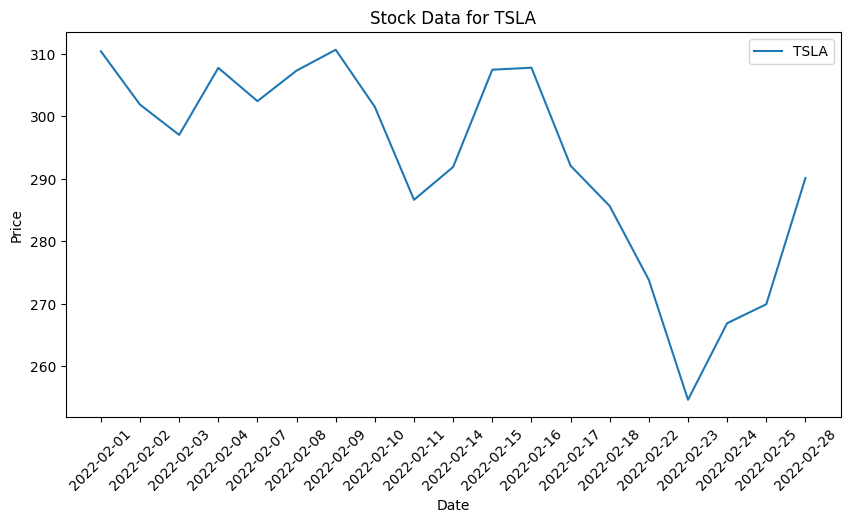

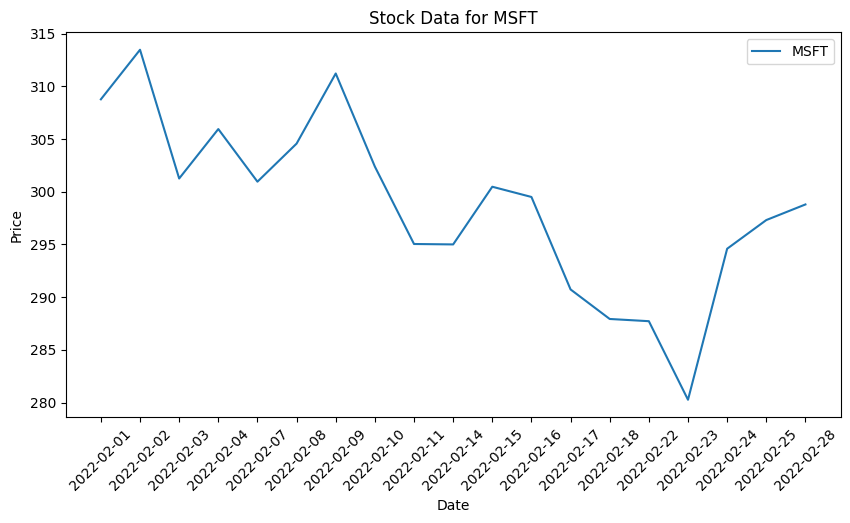

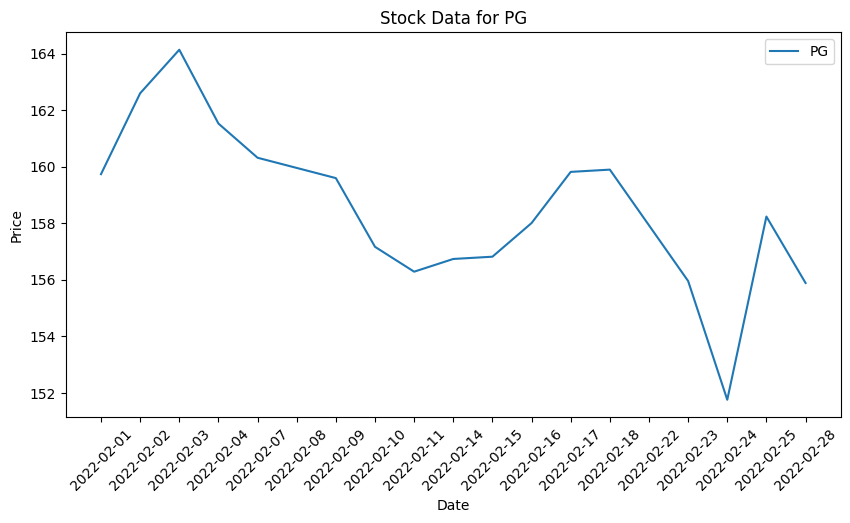

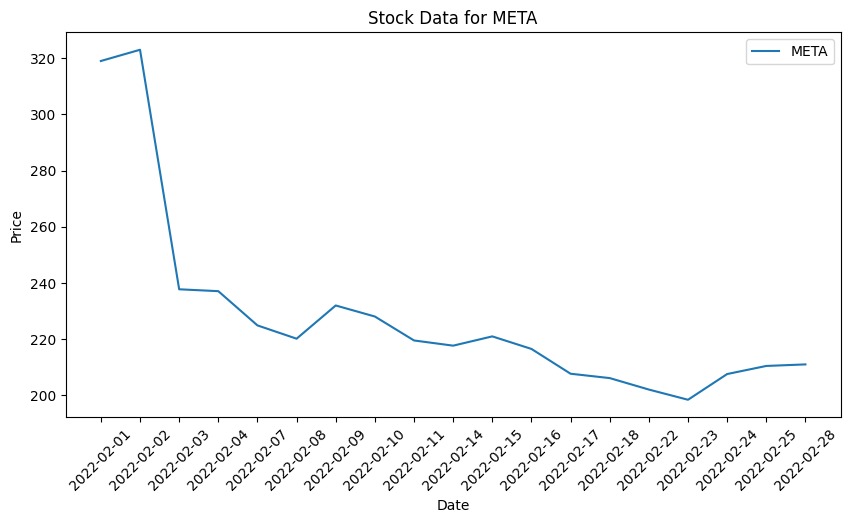

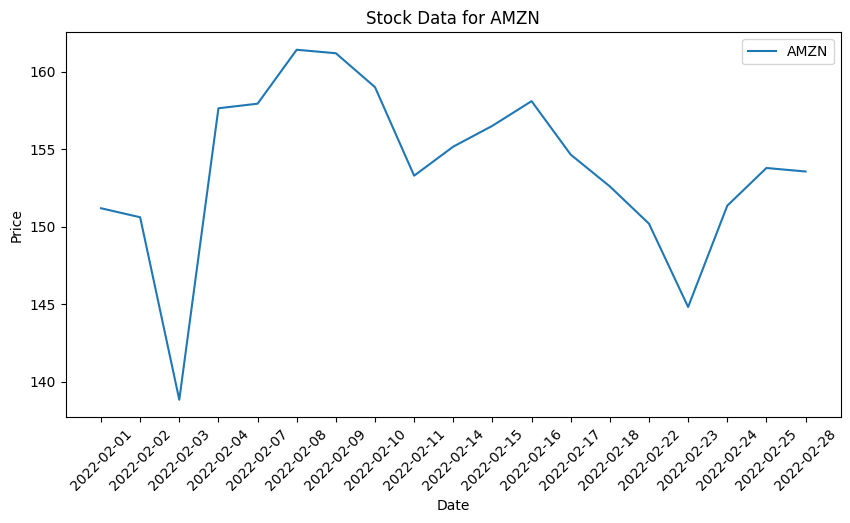

In [236]:
# Define the specific date range
start_date = '2022-02-01'
end_date = '2022-02-28'

filtered_stock_data_df = test_stock_data_df[(test_stock_data_df['Date'] >= start_date) & (test_stock_data_df['Date'] <= end_date)]

for stock_name in stock_names_of_interest:
    # Filter the DataFrame for the current stock
    stock_df = filtered_stock_data_df[filtered_stock_data_df['Stock Name'] == stock_name]
    
    # Plot the stock data
    plt.figure(figsize=(10, 5))
    plt.plot(stock_df['Date'], stock_df['Close'], label=stock_name)
    plt.title(f'Stock Data for {stock_name}')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Price')
    plt.legend()
    plt.show()


In [237]:
# Display the tweet data
tweet_data_df.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [238]:
tweet_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          80793 non-null  object
 1   Tweet         80793 non-null  object
 2   Stock Name    80793 non-null  object
 3   Company Name  80793 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


In [239]:
tweet_data_df['Date'] = pd.to_datetime(tweet_data_df['Date'])
tweet_data_df['Date'] = tweet_data_df['Date'].dt.date

tweet_data_df

,Date,Tweet,Stock Name,Company Name
0,2022-09-29,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.


In [240]:
# Initialize the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentences = tweet_data_df["Tweet"]

# Function to analyze sentiment of each sentence
def analyze_sentiment(sentences):
    return analyzer.polarity_scores(sentences)

# Apply the sentiment analysis to each tweet and create new columns
tweet_data_df[['neg', 'neu', 'pos', 'compound']] = tweet_data_df['Tweet'].apply(lambda x: pd.Series(analyze_sentiment(x)))

# tweet_data_df = tweet_data_df.drop(columns=['sentiment_scores'])

tweet_data_df.head(20)

,Date,Tweet,Stock Name,Company Name,neg,neu,pos,compound
0,2022-09-29,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",0.125,0.763,0.113,0.0772
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",0.000,1.000,0.000,0.0000
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",0.000,0.954,0.046,0.2960
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",0.273,0.590,0.137,-0.7568
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",0.526,0.474,0.000,-0.8750
5,2022-09-29,@RealDanODowd @Tesla This is you https://t.co/...,TSLA,"Tesla, Inc.",0.000,1.000,0.000,0.0000
6,2022-09-29,For years @WholeMarsBlog viciously silenced @T...,TSLA,"Tesla, Inc.",0.298,0.662,0.041,-0.9359
7,2022-09-29,$NIO just because I'm down money doesn't mean ...,TSLA,"Tesla, Inc.",0.155,0.690,0.155,0.2500
8,2022-09-29,50 likes for some $SPY $TSLA charts to study!\...,TSLA,"Tesla, Inc.",0.000,0.764,0.236,0.4753
9,2022-09-29,@MrJames__321 @KellyRoofing @TeslaSolar @elonm...,TSLA,"Tesla, Inc.",0.272,0.728,0.000,-0.8625


In [241]:
# Function to normalize sentiment based on the thresholds
def normalize_sentiment(compound):
    if compound >= 0.05:
        return 1  # Positive sentiment normalized to 1
    elif -0.05 < compound < 0.05:
        return 0  # Neutral sentiment normalized to 0
    elif compound <= -0.05:
        return -1  # Negative sentiment normalized to -1

# Apply the normalization function to the 'compound_score' column
tweet_data_df['normalized_sentiment'] = tweet_data_df['compound'].apply(normalize_sentiment)

# Display the DataFrame with the normalized sentiment
tweet_data_df.head(20)

,Date,Tweet,Stock Name,Company Name,neg,neu,pos,compound,normalized_sentiment
0,2022-09-29,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",0.125,0.763,0.113,0.0772,1
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",0.000,1.000,0.000,0.0000,0
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",0.000,0.954,0.046,0.2960,1
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",0.273,0.590,0.137,-0.7568,-1
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",0.526,0.474,0.000,-0.8750,-1
5,2022-09-29,@RealDanODowd @Tesla This is you https://t.co/...,TSLA,"Tesla, Inc.",0.000,1.000,0.000,0.0000,0
6,2022-09-29,For years @WholeMarsBlog viciously silenced @T...,TSLA,"Tesla, Inc.",0.298,0.662,0.041,-0.9359,-1
7,2022-09-29,$NIO just because I'm down money doesn't mean ...,TSLA,"Tesla, Inc.",0.155,0.690,0.155,0.2500,1
8,2022-09-29,50 likes for some $SPY $TSLA charts to study!\...,TSLA,"Tesla, Inc.",0.000,0.764,0.236,0.4753,1
9,2022-09-29,@MrJames__321 @KellyRoofing @TeslaSolar @elonm...,TSLA,"Tesla, Inc.",0.272,0.728,0.000,-0.8625,-1


In [242]:
tweets_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']

# Filter DataFrame to only include specified stocks
condensed_tweet_data_df = tweet_data_df[tweet_data_df['Stock Name'].isin(tweets_of_interest)]
mean_score_df = condensed_tweet_data_df.groupby(['Date','Stock Name'])['compound'].mean()
mean_score_df = mean_score_df.reset_index()
mean_score_df.set_index(['Date', 'Stock Name'], inplace=True)
# mean_score_df.set_index(['Date','Stock Name'], inplace=True)

mean_score_df

compound
Date       Stock Name          
2021-09-30 AMZN        0.256980
           META        0.472467
           MSFT        0.256980
           PG          0.256980
           TSLA        0.251634
...                         ...
2022-09-29 AMZN        0.086080
           META       -0.051600
           MSFT        0.086080
           PG          0.086080
           TSLA        0.057709

[1768 rows x 1 columns]

In [243]:
new_stock_data_df = test_stock_data_df[['Date', 'Stock Name', 'Open', 'Close', 'Price Change']]
new_tweet_data_df = mean_score_df[['Date', 'Stock Name', 'compound']]
merged_df = pd.merge(new_stock_data_df, new_tweet_data_df, on=['Date', 'Stock Name'], how='inner')

merged_df

KeyError: "['Date', 'Stock Name'] not in index"

In [191]:
condensed_df = mean_score_df.unstack()

condensed_df

Stock Name,AMZN,META,MSFT,PG,TSLA
Date,,,,,
2021-09-30,0.256980,0.472467,0.256980,0.256980,0.251634
2021-10-01,0.359650,0.230900,0.359650,0.359650,0.222412
2021-10-02,-0.000700,0.860000,-0.000700,-0.000700,0.307714
2021-10-03,0.822500,0.276900,0.822500,0.822500,0.267680
2021-10-04,0.279425,0.046167,0.279425,0.279425,0.151775
...,...,...,...,...,...
2022-09-25,0.247900,-0.709600,0.247900,0.247900,0.150072
2022-09-26,-0.068714,NaN,-0.068714,-0.068714,0.114828
2022-09-27,-0.186740,NaN,-0.186740,-0.186740,0.225460
